In [224]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
#Set numpy and Tensorflow random seed to mask sure experiment reproducible(only works in CPU mode).
from numpy.random import seed
seed(123)
from tensorflow.compat.v1 import set_random_seed
set_random_seed(123)
from skimage import io, draw
import cv2

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir())

# Any results you write to the current directory are saved as output.

['.ipynb_checkpoints', 'Untitled.ipynb', 'train.txt', 'how does it works wtf .ipynb', 'val.txt', 'train_segmentation.ipynb', 'testing.h5', '720p_color.avi', 'model-sdc-seg-v2.h5', 'labels', '__pycache__', 'bruit.avi', 'Unet_data', 'video.ipynb', '720p.avi', 'good_but_bad.h5', 'eval_seg.ipynb', 'road_following_Unet.py', 'bruit_modifie.avi', 'data', 'testing.ipynb', '720_modifiee.avi', 'Segmentation.py', 'dataset.yaml', 'masks', 'model-sdc-seg-v2_good_but_bad.h5', 'learning.ipynb', 'images', 'get_all_masks.ipynb', 'first_full_model']


In [226]:
image_path = 'data/images/'
mask_path = 'data/masks/'
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

In [227]:
image_list = ['data/images/'+item+'.jpg' for item in pd.Series([item.split('mask_')[-1][:-4] for item in mask_list]).sort_values().tolist()]

In [228]:
mask_list = ['data/masks/mask_'+item+'.png' for item in pd.Series([item.split('mask_')[-1][:-4] for item in mask_list]).sort_values().tolist()]

/tmp/ipykernel_3142/1718456383.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
/tmp/ipykernel_3142/1718456383.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmentation')

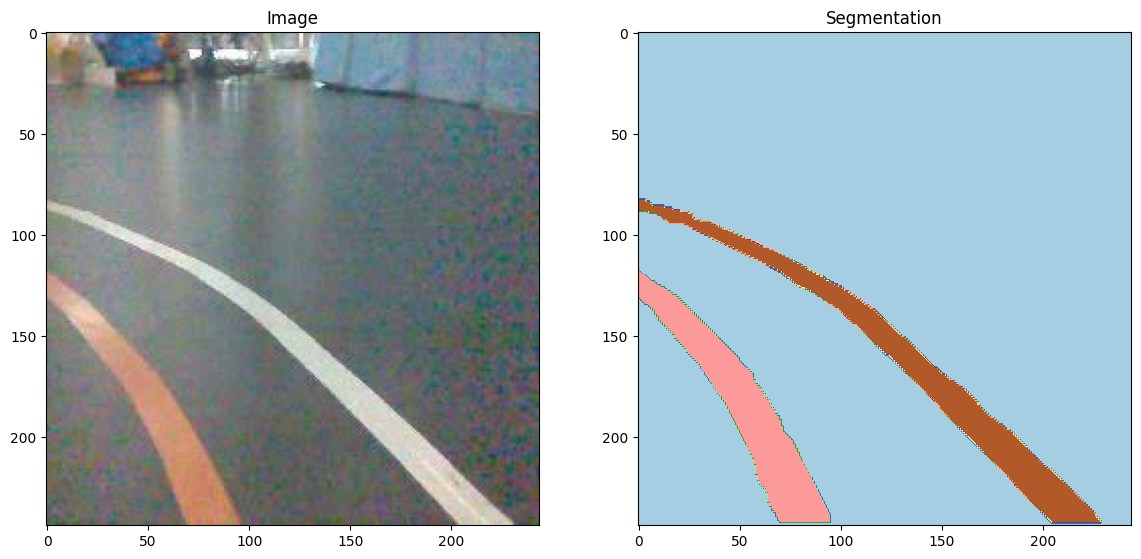

In [229]:
from skimage import io

N = 145
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])
#mask = np.where(mask != 0, 1, mask)


fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask, cmap='Paired')
arr[1].set_title('Segmentation')

In [7]:
from tqdm import tqdm

In [8]:
height = 720
width = 1280
images = np.zeros((len(image_list), height, width, 3), dtype=np.int16)
masks = np.zeros((len(image_list), height, width, 1), dtype=np.int8)

def augment_dim_arr(arr_census, augmentation):
    new_array = np.broadcast_to(arr_census[:, :, np.newaxis], arr_census.shape + (1,))
    new_array = np.broadcast_to(new_array, arr_census.shape + (augmentation,))
    return new_array


for n in tqdm(range(len(image_list))):
    img = cv2.resize(io.imread(image_list[n]), (1280,720), interpolation = cv2.INTER_NEAREST)
    #img = cv2.resize(cv2.cvtColor(cv2.imread(image_list[n], cv2.IMREAD_GRAYSCALE), cv2.COLOR_GRAY2RGB), (1280,720), interpolation = cv2.INTER_NEAREST)
    mask = cv2.resize(io.imread(mask_list[n]), (1280,720))
    #mask_road = np.zeros((height, width, 1), dtype=np.int8)
    #mask_road[np.where(mask==255)[0], np.where(mask==255)[1]]=1
    #mask_road[np.where(mask==100)[0], np.where(mask==100)[1]]=2
    
    mask = np.where(mask>=225, 255, mask)
    mask = np.where((mask<225) & (mask >=110), 0, mask)
    mask = np.where((mask<110) & (mask >=75), 100, mask)
    mask = np.where(mask<75, 0, mask)
    
    
    mask_road = np.where(mask == 255, 1, mask)
    mask_road = np.where(mask_road == 100, 2, mask_road)
    mask_road = np.expand_dims(mask_road, axis=2)
    
    images[n] = img
    masks[n] = mask_road

100%|█████████████████████████████████████████| 781/781 [00:08<00:00, 93.37it/s]


In [9]:
np.random.seed(123)
shuffle_ids = np.array([i for i in range(len(masks))])
np.random.shuffle(shuffle_ids)
train_ids = shuffle_ids[:int(len(masks)*0.8)]
val_ids = shuffle_ids[int(len(masks)*0.8):int(len(masks)*0.8+100)]
test_ids = shuffle_ids[int(len(masks)*0.8+100):]

In [10]:
train_images, train_masks = images[train_ids], masks[train_ids]
val_images, val_masks = images[val_ids], masks[val_ids]
test_images, test_masks = images[test_ids], masks[test_ids]

In [11]:
train_images.shape, val_images.shape, test_images.shape

((624, 720, 1280, 3), (100, 720, 1280, 3), (57, 720, 1280, 3))

In [ ]:
cmp = 0
for image in train_images:
    io.imsave("Unet_data/train_imgs/train/img"+str(cmp)+'.png', image.astype(np.uint8))
    cmp+=1

In [ ]:
cmp = 0
for image in train_masks:
    io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
              #np.repeat(image.astype(np.uint8)[:, :, np.newaxis], 3, axis=2))
    cmp+=1

In [ ]:
cmp

In [ ]:
cmp = 624+1
for image in test_masks:
    io.imsave("Unet_data/test_masks/test/img"+str(cmp)+'.png', np.squeeze(image))
              #np.repeat(image.astype(np.uint8)[:, :, np.newaxis], 3, axis=2))
    cmp+=1

In [ ]:
cmp = 624+1
for image in test_images:
    io.imsave("Unet_data/test_imgs/test/img"+str(cmp)+'.png', image.astype(np.uint8))
              #np.repeat(image.astype(np.uint8)[:, :, np.newaxis], 3, axis=2))
    cmp+=1

In [ ]:
cmp

In [ ]:
cmp = 682+1
for image in val_images:
    io.imsave("Unet_data/val_imgs/val/img"+str(cmp)+'.png', image.astype(np.uint8))
              #np.repeat(image.astype(np.uint8)[:, :, np.newaxis], 3, axis=2))
    cmp+=1

In [ ]:
cmp = 682+1
for image in val_masks:
    io.imsave("Unet_data/val_masks/val/img"+str(cmp)+'.png', np.squeeze(image))
              #np.repeat(image.astype(np.uint8)[:, :, np.newaxis], 3, axis=2))
    cmp+=1


 Which backbone model do you want to use? 
 -'mobilenet' or 'mobilenetv2': efficient and light for real-word application 
 -'inceptionv3': Deep Convolutional Neural Network with sparsely connected architecture developped by Google (using different types of convolutional blocks at each layer) 
 -'resnet18','resnet34','resnet50','resnet101' or'resnet152': core idea of this model is  'identity shortcut connection' that skips one or more layers 
 We encourage you to try mobilenet first to see if it is sufficient for your segmentation task 
mobilenet

 Which loss function do you want to use ? 
 -'cross_entropy': fastest to compute, 
 -'dice_loss': Overlap measure that performs better at class imbalanced problems 
 -'focal_loss' : To down-weight the contribution of easy examples so that the CNN focuses more on hard examples 
 Could also be a mix of those loss functions 
 Examples : 
 - cross_entropy + dice_loss 
 - dice_loss + focal_loss 
 cross_entropy
Do you want Data Augmentation ? Yes o

2023-06-06 20:06:36.998709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - ETA: 0s - loss: 0.1786 - accuracy: 0.8769 - iou_score: 0.3240

2023-06-06 20:09:43.329413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 188s 2s/step - loss: 0.1786 - accuracy: 0.8769 - iou_score: 0.3240 - val_loss: 0.1724 - val_accuracy: 0.8657 - val_iou_score: 0.3481
Epoch 2/50
100/100 [==============================] - 180s 2s/step - loss: 0.0633 - accuracy: 0.8971 - iou_score: 0.3512 - val_loss: 0.0611 - val_accuracy: 0.8943 - val_iou_score: 0.3589
Epoch 3/50
100/100 [==============================] - 175s 2s/step - loss: 0.0560 - accuracy: 0.8954 - iou_score: 0.3528 - val_loss: 0.0504 - val_accuracy: 0.9002 - val_iou_score: 0.3516
Epoch 4/50
100/100 [==============================] - 175s 2s/step - loss: 0.0502 - accuracy: 0.8962 - iou_score: 0.3573 - val_loss: 0.0501 - val_accuracy: 0.9125 - val_iou_score: 0.3389
Epoch 5/50
100/100 [==============================] - 174s 2s/step - loss: 0.0502 - accuracy: 0.8944 - iou_score: 0.3579 - val_loss: 0.0367 - val_accuracy: 0.8967 - val_iou_score: 0.3783
Epoch 6/50
100/100 [==============================] - 174s 2s/step - loss: 0

Epoch 45/50
100/100 [==============================] - 170s 2s/step - loss: 0.0428 - accuracy: 0.8956 - iou_score: 0.3630 - val_loss: 0.0606 - val_accuracy: 0.9003 - val_iou_score: 0.4078
Epoch 46/50
100/100 [==============================] - 170s 2s/step - loss: 0.0397 - accuracy: 0.8952 - iou_score: 0.3667 - val_loss: 0.0333 - val_accuracy: 0.8862 - val_iou_score: 0.3762
Epoch 47/50
100/100 [==============================] - 169s 2s/step - loss: 0.0387 - accuracy: 0.8970 - iou_score: 0.3652 - val_loss: 0.0337 - val_accuracy: 0.8799 - val_iou_score: 0.3761
Epoch 48/50
100/100 [==============================] - 170s 2s/step - loss: 0.0425 - accuracy: 0.8951 - iou_score: 0.3643 - val_loss: 0.0310 - val_accuracy: 0.9198 - val_iou_score: 0.3784
Epoch 49/50
100/100 [==============================] - 170s 2s/step - loss: 0.0415 - accuracy: 0.8978 - iou_score: 0.3652 - val_loss: 0.0340 - val_accuracy: 0.9076 - val_iou_score: 0.3587
Epoch 50/50
100/100 [==============================] - 170s 

2023-06-06 22:32:11.984636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-06-06 22:32:12.049444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-06-06 22:32:12.114335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-06-06

INFO:tensorflow:Assets written to: Unet.pt/assets


INFO:tensorflow:Assets written to: Unet.pt/assets



 What do you want to do now ? 
 -'save_model' 
 -'plot_history' 
 -'show_predictions' 
 -'continue_training' 
 -'predict_on_new_data' 
 -'end' 
show_prediction
Sorry, your response must not be in ['save_model', 'plot_history', 'show_predictions', 'continue_training', 'end']

 What do you want to do now ? 
 -'save_model' 
 -'plot_history' 
 -'show_predictions' 
 -'continue_training' 
 -'predict_on_new_data' 
 -'end' 
show_predictions


/home/tom/.local/lib/python3.11/site-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/tom/.local/lib/python3.11/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


(6, 224, 224, 3)
(6, 224, 224, 1)
(224, 224, 3)
(224, 224, 1)
1/1 [==============================] - 1s 544ms/step


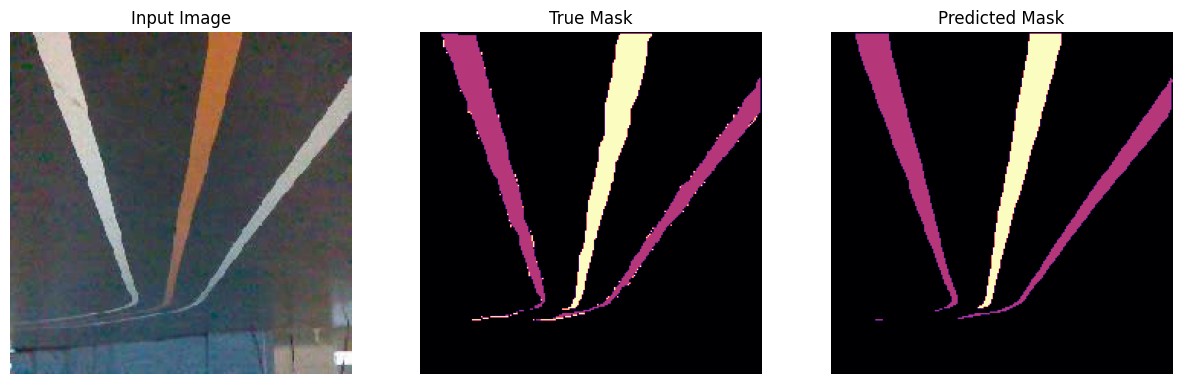


 What do you want to do now ? 
 -'save_model' 
 -'plot_history' 
 -'show_predictions' 
 -'continue_training' 
 -'predict_on_new_data' 
 -'end' 
plot_history


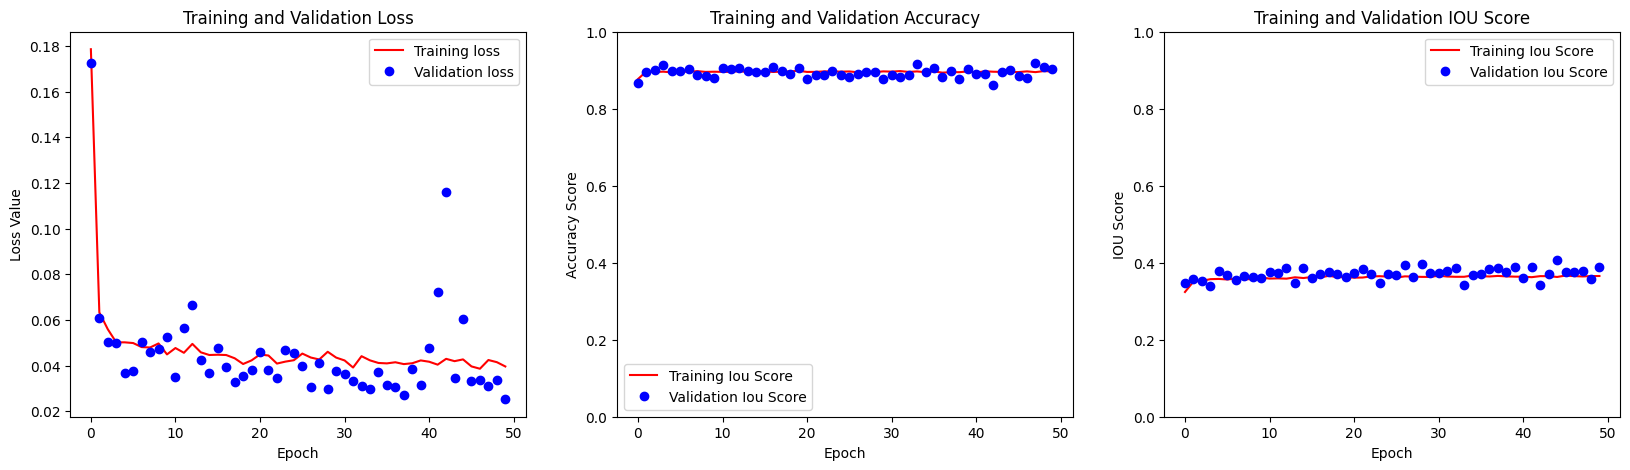


 What do you want to do now ? 
 -'save_model' 
 -'plot_history' 
 -'show_predictions' 
 -'continue_training' 
 -'predict_on_new_data' 
 -'end' 
end


In [63]:
from Segmentation import segmentation

seg = segmentation('Unet_data/', ['Line1', 'Line2', 'Nothing'])

(6, 224, 224, 3)
(6, 224, 224, 1)
(224, 224, 3)
(224, 224, 1)
1/1 [==============================] - 0s 58ms/step


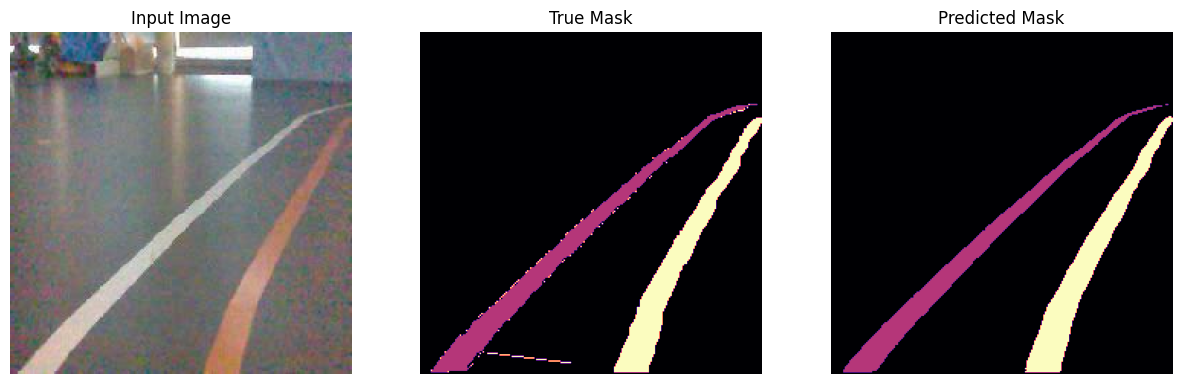

In [64]:
image, mask, sample_image, sample_mask = seg.show_predictions()

In [12]:
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

class MeanMetricWrapper(tf.keras.metrics.Mean):
    def __init__(self, name='mean_metric', dtype=None):
        super(MeanMetricWrapper, self).__init__(name=name, dtype=dtype)

    def get_config(self):
        return {'name': self.name}

    @classmethod
    def from_config(cls, config):
        return cls(name=config['name'])

model = tf.keras.models.load_model("first_full_model", custom_objects={'MeanMetricWrapper': MeanMetricWrapper})

2023-06-07 11:48:16.582803: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


1/1 [==============================] - 0s 58ms/step


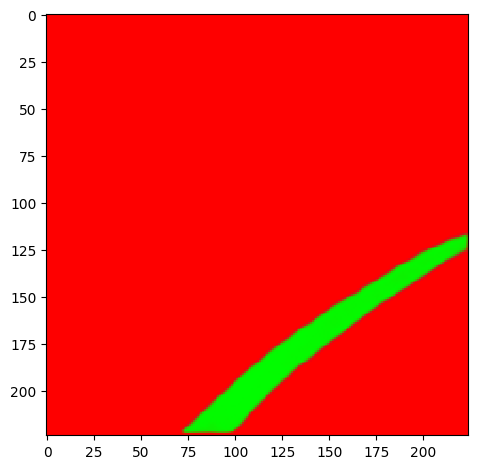

In [218]:
img_dem = (cv2.resize(io.imread("Unet_data/test_imgs/test/img630.png")*1./255, (224,224)))
img_dem = np.expand_dims(img_dem, axis=0)

res_dem = model.predict(img_dem)[0]
io.imshow(res_dem)

In [219]:
orange_lines = compute_mask(res_dem[:,:,2])
white_lines = compute_mask(res_dem[:,:,1])

/home/tom/.local/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


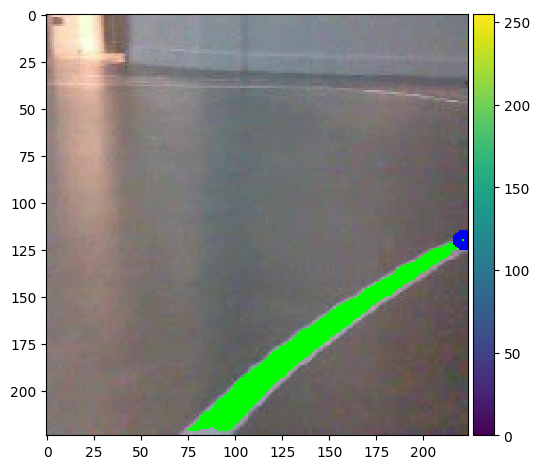

In [220]:
img_res = img_dem[0].copy()
img_res[orange_lines != 0] = [1, 0, 0]
img_res[white_lines != 0] = [0, 1, 0]

try:
    cv2.circle(img_res, apex_from_mask(orange_lines)[::-1], 3, (0, 0, 255), 3)
except:
    cv2.circle(img_res, apex_from_mask(white_lines)[::-1], 3, (0, 0, 255), 3)

io.imshow(img_res)

In [223]:
temp = apex_from_mask(orange_lines)
if temp:
    print('yooo')

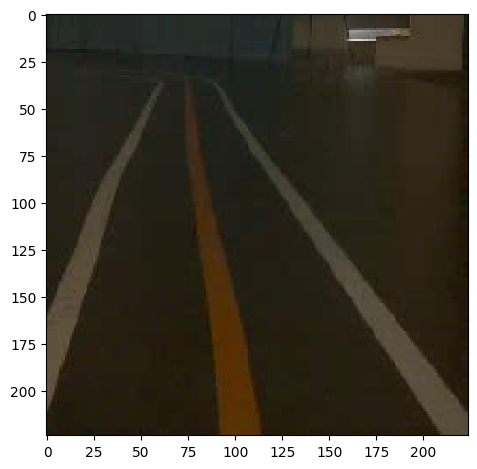

In [217]:
io.imshow(img_dem[0])

In [189]:
orange_lines

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [166]:
def compute_mask(mask):
    res = mask.copy()
    res = np.where(res >= 0.95, 1, res)
    res = np.where(res < 0.95, 0, res)
    return res

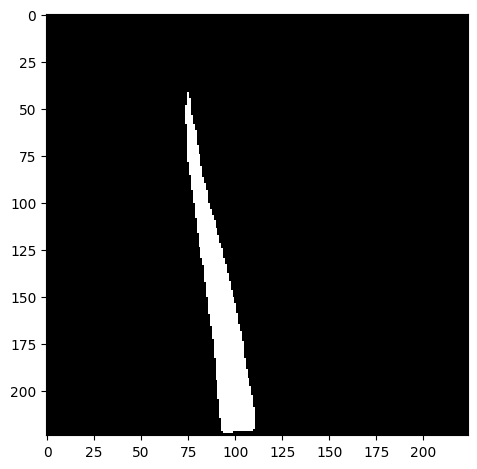

In [192]:
io.imshow(orange_lines)

In [194]:
apex_from_mask(orange_lines)

(112, 84)

(array([[  0.,  15.,  17., ...,   3.,   1., 170.],
        [ 38.,   6.,   2., ...,   1.,   1., 169.],
        [ 42.,   2.,   1., ...,   4.,   2., 168.],
        ...,
        [  0.,   5.,   2., ...,   2.,   2., 209.],
        [  0.,   0.,   0., ...,   1.,   3., 215.],
        [  0.,   0.,   0., ...,   0.,   0., 224.]]),
 array([1.32526678e-04, 1.00119241e-01, 2.00105965e-01, 3.00092667e-01,
        4.00079399e-01, 5.00066102e-01, 6.00052834e-01, 7.00039566e-01,
        8.00026238e-01, 9.00012970e-01, 9.99999702e-01]),
 <a list of 224 BarContainer objects>)

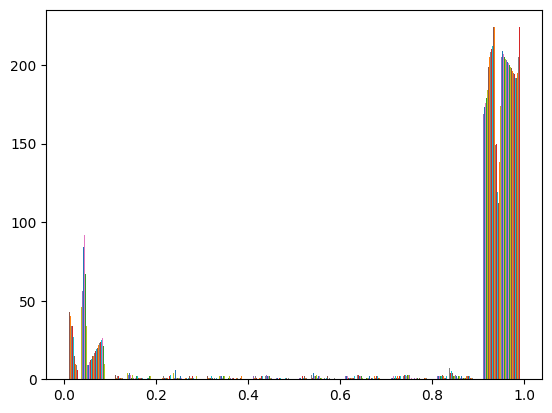

In [161]:
plt.hist(res_dem[:,:,0])

In [196]:
def apex_from_mask(mask):
    height, width = mask.shape

    # Calculate the middle row index
    middle_row = height // 2

   # Initialize variables to track the indices of -1 values
    first_neg_one_idx = None
    last_neg_one_idx = None

    # Iterate over the rows from the middle row to the bottom row
    for y in range(middle_row, height):
        row = mask[y, :]
        # Check if there are any -1 values in the row
        if 1 in row:
            # If this is the first row with -1 values, record the indices and the line index
            if first_neg_one_idx is None:
                first_neg_one_idx = np.where(row == 1)[0][0]
                last_neg_one_idx = np.where(row == 1)[0][-1]
                line_idx = y
                center_idx = (first_neg_one_idx + last_neg_one_idx) // 2
                return (line_idx, center_idx )
      
    for y in range(0, middle_row):
        row = mask[y, :]
        # Check if there are any -1 values in the row
        if 1 in row:
            # If this is the first row with -1 values, record the indices and the line index
            if first_neg_one_idx is None:
                first_neg_one_idx = np.where(row == 1)[0][0]
                last_neg_one_idx = np.where(row == 1)[0][-1]
                line_idx = y
                center_idx = (first_neg_one_idx + last_neg_one_idx) // 2
                return (line_idx, center_idx )

    return None

def draw_circle(img, coord, r=5):
    x,y = coord
    x = int(x)
    y = int(y)
    """
    Draw a circle of radius r on the passed img 
    on coordinates (x,y)
    """
    mask = np.zeros_like(img[:, :, 0])
    rr, cc = draw.disk((x, y), r, shape=mask.shape)
    mask[rr, cc] = 1

    # Apply the mask to the image
    img[mask == 1, :] = [255, 0, 0]  # Set the circle color to red
    
    return img

In [21]:
apex_from_mask(res_filtered)

(112, 83)

In [216]:
import os
from tqdm import tqdm

for item in tqdm(["Unet_data/test_imgs/test/"+itm for itm in os.listdir('Unet_data/test_imgs/test/')]):
    img_dem = (cv2.resize(io.imread(item)*1./255, (224,224)))
    img_dem = np.expand_dims(img_dem, axis=0)

    res_dem = model.predict(img_dem)[0]
    orange_lines = compute_mask(res_dem[:,:,2])
    white_lines = compute_mask(res_dem[:,:,1])


    img_res = img_dem[0].copy()
    img_res[orange_lines != 0] = [1, 0, 0]
    img_res[white_lines != 0] = [0, 1, 0]

    try:
        cv2.circle(img_res, apex_from_mask(orange_lines)[::-1], 3, (0, 0, 1), 3)
    except:
        cv2.circle(img_res, apex_from_mask(white_lines)[::-1], 3, (0, 0, 1), 3)
    
    io.imsave('Unet_data/prediction_on_test/'+item.split('/')[-1], (img_res*255).astype('uint8'))

  0%|                                                    | 0/57 [00:00<?, ?it/s]

1/1 [==============================] - 0s 57ms/step


  2%|▊                                           | 1/57 [00:00<00:08,  6.42it/s]

1/1 [==============================] - 0s 58ms/step


  4%|█▌                                          | 2/57 [00:00<00:08,  6.80it/s]

1/1 [==============================] - 0s 62ms/step


  5%|██▎                                         | 3/57 [00:00<00:08,  6.70it/s]

1/1 [==============================] - 0s 61ms/step


  7%|███                                         | 4/57 [00:00<00:07,  6.77it/s]

1/1 [==============================] - 0s 83ms/step


  9%|███▊                                        | 5/57 [00:00<00:08,  6.49it/s]

1/1 [==============================] - 0s 75ms/step


 11%|████▋                                       | 6/57 [00:00<00:07,  6.57it/s]

1/1 [==============================] - 0s 67ms/step


 12%|█████▍                                      | 7/57 [00:01<00:07,  6.61it/s]

1/1 [==============================] - 0s 64ms/step


 14%|██████▏                                     | 8/57 [00:01<00:07,  6.89it/s]

1/1 [==============================] - 0s 66ms/step


 16%|██████▉                                     | 9/57 [00:01<00:06,  6.87it/s]

1/1 [==============================] - 0s 63ms/step


 18%|███████▌                                   | 10/57 [00:01<00:07,  6.71it/s]

1/1 [==============================] - 0s 64ms/step


 19%|████████▎                                  | 11/57 [00:01<00:06,  6.84it/s]

1/1 [==============================] - 0s 65ms/step


 21%|█████████                                  | 12/57 [00:01<00:06,  6.84it/s]

1/1 [==============================] - 0s 74ms/step


 23%|█████████▊                                 | 13/57 [00:01<00:06,  6.66it/s]

1/1 [==============================] - 0s 70ms/step


 25%|██████████▌                                | 14/57 [00:02<00:06,  6.56it/s]

1/1 [==============================] - 0s 66ms/step


 26%|███████████▎                               | 15/57 [00:02<00:06,  6.60it/s]

1/1 [==============================] - 0s 62ms/step


 28%|████████████                               | 16/57 [00:02<00:05,  6.89it/s]

1/1 [==============================] - 0s 61ms/step


 30%|████████████▊                              | 17/57 [00:02<00:05,  6.80it/s]

1/1 [==============================] - 0s 61ms/step


 32%|█████████████▌                             | 18/57 [00:02<00:05,  6.90it/s]

1/1 [==============================] - 0s 67ms/step


 33%|██████████████▎                            | 19/57 [00:02<00:05,  6.81it/s]

1/1 [==============================] - 0s 88ms/step


 35%|███████████████                            | 20/57 [00:02<00:05,  6.47it/s]

1/1 [==============================] - 0s 70ms/step


 37%|███████████████▊                           | 21/57 [00:03<00:05,  6.48it/s]

1/1 [==============================] - 0s 72ms/step


 39%|████████████████▌                          | 22/57 [00:03<00:05,  6.63it/s]

1/1 [==============================] - 0s 64ms/step


 40%|█████████████████▎                         | 23/57 [00:03<00:05,  6.80it/s]

1/1 [==============================] - 0s 71ms/step


 42%|██████████████████                         | 24/57 [00:03<00:05,  6.57it/s]

1/1 [==============================] - 0s 74ms/step


 44%|██████████████████▊                        | 25/57 [00:03<00:04,  6.43it/s]

1/1 [==============================] - 0s 73ms/step


 46%|███████████████████▌                       | 26/57 [00:03<00:04,  6.38it/s]

1/1 [==============================] - 0s 67ms/step


 47%|████████████████████▎                      | 27/57 [00:04<00:04,  6.50it/s]

1/1 [==============================] - 0s 70ms/step


 49%|█████████████████████                      | 28/57 [00:04<00:04,  6.53it/s]

1/1 [==============================] - 0s 61ms/step


 51%|█████████████████████▉                     | 29/57 [00:04<00:04,  6.66it/s]

1/1 [==============================] - 0s 63ms/step


 53%|██████████████████████▋                    | 30/57 [00:04<00:03,  6.84it/s]

1/1 [==============================] - 0s 71ms/step


 54%|███████████████████████▍                   | 31/57 [00:04<00:03,  6.82it/s]

1/1 [==============================] - 0s 63ms/step


 56%|████████████████████████▏                  | 32/57 [00:04<00:03,  6.91it/s]

1/1 [==============================] - 0s 67ms/step


 58%|████████████████████████▉                  | 33/57 [00:04<00:03,  7.01it/s]

1/1 [==============================] - 0s 67ms/step


 60%|█████████████████████████▋                 | 34/57 [00:05<00:03,  6.79it/s]

1/1 [==============================] - 0s 68ms/step


 61%|██████████████████████████▍                | 35/57 [00:05<00:03,  6.95it/s]

1/1 [==============================] - 0s 68ms/step


 63%|███████████████████████████▏               | 36/57 [00:05<00:03,  6.76it/s]

1/1 [==============================] - 0s 67ms/step


 65%|███████████████████████████▉               | 37/57 [00:05<00:02,  6.76it/s]

1/1 [==============================] - 0s 67ms/step


 67%|████████████████████████████▋              | 38/57 [00:05<00:02,  6.77it/s]

1/1 [==============================] - 0s 66ms/step


 68%|█████████████████████████████▍             | 39/57 [00:05<00:02,  6.77it/s]

1/1 [==============================] - 0s 65ms/step


 70%|██████████████████████████████▏            | 40/57 [00:05<00:02,  6.86it/s]

1/1 [==============================] - 0s 65ms/step


 72%|██████████████████████████████▉            | 41/57 [00:06<00:02,  6.89it/s]

1/1 [==============================] - 0s 66ms/step


 74%|███████████████████████████████▋           | 42/57 [00:06<00:02,  6.92it/s]

1/1 [==============================] - 0s 67ms/step


 75%|████████████████████████████████▍          | 43/57 [00:06<00:02,  6.90it/s]

1/1 [==============================] - 0s 64ms/step


 77%|█████████████████████████████████▏         | 44/57 [00:06<00:01,  6.97it/s]

1/1 [==============================] - 0s 72ms/step


 79%|█████████████████████████████████▉         | 45/57 [00:06<00:01,  6.79it/s]

1/1 [==============================] - 0s 71ms/step


 81%|██████████████████████████████████▋        | 46/57 [00:06<00:01,  6.78it/s]

1/1 [==============================] - 0s 66ms/step


 82%|███████████████████████████████████▍       | 47/57 [00:06<00:01,  6.83it/s]

1/1 [==============================] - 0s 65ms/step


 84%|████████████████████████████████████▏      | 48/57 [00:07<00:01,  6.84it/s]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████▉      | 49/57 [00:07<00:01,  6.87it/s]

1/1 [==============================] - 0s 64ms/step


 88%|█████████████████████████████████████▋     | 50/57 [00:07<00:01,  6.75it/s]

1/1 [==============================] - 0s 58ms/step


 89%|██████████████████████████████████████▍    | 51/57 [00:07<00:00,  7.06it/s]

1/1 [==============================] - 0s 68ms/step


 91%|███████████████████████████████████████▏   | 52/57 [00:07<00:00,  6.78it/s]

1/1 [==============================] - 0s 76ms/step


 93%|███████████████████████████████████████▉   | 53/57 [00:07<00:00,  6.66it/s]

1/1 [==============================] - 0s 69ms/step


 95%|████████████████████████████████████████▋  | 54/57 [00:08<00:00,  6.25it/s]

1/1 [==============================] - 0s 69ms/step


 96%|█████████████████████████████████████████▍ | 55/57 [00:08<00:00,  6.30it/s]

1/1 [==============================] - 0s 69ms/step


 98%|██████████████████████████████████████████▏| 56/57 [00:08<00:00,  6.43it/s]

1/1 [==============================] - 0s 66ms/step


100%|███████████████████████████████████████████| 57/57 [00:08<00:00,  6.71it/s]
